# PyTorch class-based neural net using GPU if avaliable

This notebook is a repeat of the class-based method for PyTorch, but checks whether a GPU is available. GPUs signfocantly speed up neural network training when there are many features present, batch sizes are large, or the network is large.

For smaller numbers of features, and for small networks, running on CPU may be faster (especially with modern multi-core CPUs).

As opposed to TensorFlow, we must modify the code a little to use the GPU if it is available. We need to pass both the model and the data to the GPU as part of the code.

## Load modules

In [1]:
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

# pytorch
import torch
from torch.autograd import Variable
import torch.nn.functional as F

## Download data if not previously downloaded

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)
    # Make all data 'float' type
    data = data.astype(float)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Define function to scale data

In neural networks it is common to to scale input data 0-1 rather than use standardisation (subtracting mean and dividing by standard deviation) of each feature).

In [3]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

## Load data

In [4]:
data = pd.read_csv('data/processed_data.csv')
data.drop('PassengerId', inplace=True, axis=1)
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'
# Convert to NumPy as required for k-fold splits
X_np = X.values
y_np = y.values

## Check whether a GPU is available 

The GPU must be of the 'CUDA' type (usually a NVIDIA GPU).

In [5]:
torch.cuda.is_available()

True

# Set up neural net

Here we use the class-based method to set up a PyTorch neural network. The network is the same as the sequential network we previously used, but is built using 

We will put construction of the neural net into a separate function.

The neural net is a relatively simple network. The inputs are connected to two hidden layers (of 240 and 50 nodes) before being connected to two output nodes corresponding to each class (died and survived). It also contains some useful additions (batch normalisation and dropout) as described below.

The layers of the network are:

1) An input layer (which does not need to be explicitly defined when using the `Sequential` method) 

2) A linear fully-connected (dense) layer.This is defined by the number of inputs (the number of input features) and the number of nodes/outputs. Each node will receive the values of all the inputs (which will either be the feature data for the input layer, or the outputs from the previous layer - so that if the previous layer had 10 nodes, then each node of the current layer would have 10 inputs, one from each node of the previous layer). It is a linear layer because the output of the node at this point is a linear function of the dot product of the weights and input values. We will expand out feature data set up to twice the number of input features. 

3) A batch normalisation layer. This is not usually used for small models, but can increase the speed of training and stability for larger models. It is added here as an example of how to include it (in large models all dense layers would be followed by a batch normalisation layer). Using batch normalisation usually allows for a higher learning rate. The layer definition includes the number of inputs to normalise.

4) A dropout layer. This layer randomly sets outputs from the preceding layer to zero during training (a different set of outputs is zeroed for each training iteration). This helps prevent over-fitting of the model to the training data. Typically between 0.1 and 0.5 outputs are set to zero (`p=0.1` means 10% of outputs are set to zero).

5) An activation layer. In this case ReLU (rectified linear unit). ReLU activation is most common for the inner layers of a neural network. Negative input values are set to zero. Positive input values are left unchanged.

6) A second linear fully connected layer (again twice the number of input features). This is again followed by batch normalisation, dropout and ReLU activation layers.

7) A final fully connected linear layer of two nodes (more nodes could be used for more classes).

8) Apply sigmoid activation to convert each output node to range 0-1 output.

The output of the net are two numbers (corresponding to scored for died/survived) between 0 and 1. These do not necessarily add up exactly to one (if Sigmoid is replaced with SoftMax then they will add up to 1, but here we will stick to sigmoid). The one with the highest value is taken as the classification result. This structure of neural net allows for any number of classes (e.g 10 classes for digit recognition).


# Set up neural net

In [6]:
class Net(torch.nn.Module):
    
    def __init__(self, number_features):
        # Define layers
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(number_features, number_features * 2)
        self.bn1 = torch.nn.BatchNorm1d(number_features * 2)
        self.fc2 = torch.nn.Linear(number_features * 2, number_features * 2)
        self.bn2 = torch.nn.BatchNorm1d(number_features * 2)
        self.fc3 = torch.nn.Linear(number_features * 2, 2)
        
    def forward(self, x):
        # Define sequence of layers
        x = self.fc1(x) # Fully connected layer
        x = self.bn1(x) # Batch normalisation
        x = F.dropout(x, p=0.3) # Apply dropout
        x = F.relu(x) # ReLU activation
        x = self.fc2(x) # Fully connected layer
        x = self.bn2(x) # Batch normalisation
        x = F.dropout(x, p=0.3) # Apply dropout
        x = F.relu(x) # ReLU activation
        x = self.fc3(x) # Fully connected layer
        x = torch.sigmoid(x) # Sigmoid output (0-1)
        
        return x

## Select device depedning on whether a GPU is available

Thi smethod would also allow you to set a device manually, such as if you want to force CPU use.

In [7]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

# dev = "cpu"  # Force CPU use of wished (for small numebrs of features)

device = torch.device(dev)  
a = torch.zeros(4,3)    
a = a.to(device)

## Run the model with k-fold validation

In [8]:
# Set up lists to hold results
training_acc_results = []
test_acc_results = []

# Set up splits
skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(X, y)

# Loop through the k-fold splits
k_counter = 0

for train_index, test_index in skf.split(X_np, y_np):
    k_counter +=1
    print(f'K_fold {k_counter}:',end=' ')
    
    # Get X and Y train/test
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    # Scale X data
    X_train_sc, X_test_sc = scale_data(X_train, X_test)
    
    # Define network
    number_features = X_train_sc.shape[1]        
    net = Net(number_features)

    # Set use of devise (GPU or CPU)
    net = net.to(device)
    
    ### Train model
    # Note: Lots of these parameters may be fine tuned
    
    # Set batch size (cases per batch - commonly 8-64)
    batch_size = 32
    # Epochs (number of times to pass over data)
    num_epochs = 200
    # Learning rate (how much each bacth updates the model)
    learning_rate = 0.003
    # Calculate numebr of batches
    batch_no = len(X_train_sc) // batch_size
    
    # Set up optimizer for classification
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    # Train model by passing through the data the required number of epochs
    for epoch in range(num_epochs):

        # Shuffle the training data
        X_train_sc, y_train = shuffle(X_train_sc, y_train)

        # Set net to training mode
        net.train()

        for i in range(batch_no):
            
            # Get X and y batch data
            start = i * batch_size
            end = start + batch_size
            x_var = Variable(torch.FloatTensor(X_train_sc[start:end]))
            y_var = Variable(torch.LongTensor(y_train[start:end]))

            # Set use of devise (GPU or CPU)
            x_var = x_var.to(device)
            y_var = y_var.to(device)
            
            # These steps train the model: Forward + Backward + Optimize
            optimizer.zero_grad() # reset optimizer
            ypred_var = net(x_var) # predict y
            loss = criterion(ypred_var, y_var) # Calculate loss
            loss.backward() # Back propagate loss through network
            optimizer.step() # Update network to reduce loss
            
    ### Test model (print results for each k-fold iteration)

    # Set net to evaluation mode
    net.eval()

    # Get training accuracy
    test_var = Variable(torch.FloatTensor(X_train_sc))
    test_var = test_var.to(device)
    result = net(test_var)

    values, labels = torch.max(result, 1)
    y_pred_train = labels.cpu().data.numpy()
    accuracy_train = np.mean(y_pred_train == y_train)
    training_acc_results.append(accuracy_train)
 
    # Get test accuracy
    test_var = Variable(torch.FloatTensor(X_test_sc))
    test_var = test_var.to(device)
    result = net(test_var)

    values, labels = torch.max(result, 1)
    y_pred_test = labels.cpu().data.numpy()
    accuracy_test = np.mean(y_pred_test == y_test)
    print(f'{accuracy_test:0.3}')
    test_acc_results.append(accuracy_test)

K_fold 1: 0.793
K_fold 2: 0.803
K_fold 3: 0.82
K_fold 4: 0.798
K_fold 5: 0.871


## Show training and test results

In [9]:
# Show individual accuracies on training data
training_acc_results

[0.8820224719101124,
 0.8821879382889201,
 0.879382889200561,
 0.8695652173913043,
 0.8681626928471248]

In [10]:
# Show individual accuracies on test data
test_acc_results

[0.7932960893854749,
 0.8033707865168539,
 0.8202247191011236,
 0.797752808988764,
 0.8707865168539326]

In [11]:
# Get mean results
mean_training = np.mean(training_acc_results)
mean_test = np.mean(test_acc_results)

# Display each to three decimal places
print (f'{mean_training:0.3f}, {mean_test:0.3f}')

0.876, 0.817


## Plot results: Box Plot

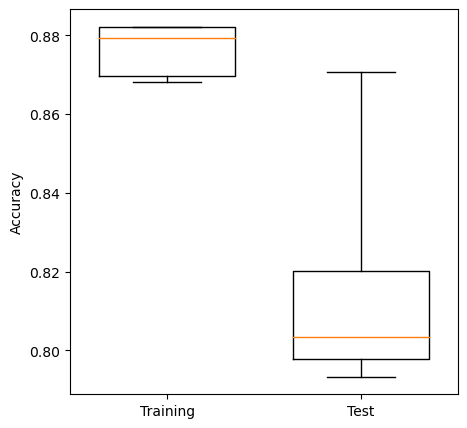

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set up X data 
x_for_box = [training_acc_results, test_acc_results]

# Set up X labels
labels = ['Training', 'Test'] 

# Set up figure
fig = plt.figure(figsize=(5,5))

# Add subplot (can be used to define multiple plots in same figure)
ax1 = fig.add_subplot(111)

# Define Box Plot (`widths` is optional)
ax1.boxplot(x_for_box, 
            widths=0.7,
            whis=10)

# Set X and Y labels
ax1.set_xticklabels(labels)
ax1.set_ylabel('Accuracy')

# Show plot
plt.show()